# visualize the data

Here, we 
1. split the whole data into training and testing sets, save them for further use, and 
2. visualize lower-dimensional representations of data and discover its patterns.

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_addons as tfa
# import pickle 
from tqdm import tqdm

# explanation tools
import shap

# plotting/visualizations
import sklearn as skl

import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 9
plt.rcParams["errorbar.capsize"] = 0.5

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')

# folders
sys.path.insert(0, proj_dir)
from helpers.dataset_utils import *
from helpers.base_model import *
from helpers.model_definitions import *

# select the GPU to be used
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# print the JS visualization code to the notebook
shap.initjs()

2022-02-19 20:32:50.594592: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-19 20:32:52.406383: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-19 20:32:52.457102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-02-19 20:32:52.457350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-02-19 20:32:52.457386: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
202

In [2]:
tf.__version__

'2.5.0'

## data

In [3]:
# whole data
file_name = f"{proj_dir}/data/emoprox2/dataframe.pkl"
data_df = pd.read_pickle(file_name)
data_df

,subj,run,ts,prox,censor
0,123,1,"[[0.184886, 0.237496, -0.869801, -0.077807, -0...","[0.3019871606242329, 0.3593604239884513, 0.416...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,123,2,"[[0.197471, 0.278874, -0.539631, 0.180507, 0.4...","[0.4512517163194395, 0.403617813223693, 0.3560...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,123,3,"[[0.060113, 0.16845, 0.202967, 0.0108, 0.27181...","[0.4950820412729392, 0.4404447770753938, 0.380...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
3,123,4,"[[-0.126394, -0.255507, -0.543931, -0.35221, -...","[0.3476834139494951, 0.3990256455963081, 0.450...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,123,5,"[[-0.167003, -0.329194, 0.711475, -0.060723, -...","[0.4991469039553821, 0.441531815585027, 0.3806...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...
711,042,2,"[[-0.058707, -0.34063, -1.171228, 0.004106, -0...","[0.4512517163194395, 0.403617813223693, 0.3560...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
712,042,3,"[[0.116604, -0.237293, -0.015429, -0.034826, -...","[0.4950820412729392, 0.4406881501898595, 0.380...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
713,042,4,"[[-0.44084, -0.046966, -1.170635, 0.289755, -0...","[0.348026457813505, 0.399483037414988, 0.45071...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
714,042,5,"[[0.409907, -0.082538, -1.07226, -0.206831, -0...","[0.4991469039553821, 0.441531815585027, 0.3806...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [4]:
train_file = f"{proj_dir}/data/emoprox2/train_dataframe.pkl"
test_file = f"{proj_dir}/data/emoprox2/test_dataframe.pkl"

if not os.path.isfile(train_file) and not os.path.isfile(test_file):
    # split subjects into train and test partitions
    subjs = pd.unique(data_df['subj'])
    train_subjs, test_subjs = split_subjs(subjs, 0.9)

    train_df = get_Xy(data_df, train_subjs)
    test_df = get_Xy(data_df, test_subjs)

    # apply censor mask
    train_df = apply_mask_Xy(train_df)
    test_df = apply_mask_Xy(test_df)

    # save these sets
    train_df.to_pickle(train_file)
    test_df.to_pickle(test_file)
else:
    train_df = pd.read_pickle(train_file)
    test_df = pd.read_pickle(test_file)

In [5]:
test_df

,X,y,mask
0,"[[0.512918, 0.547141, 0.100542, 0.026633, 1.50...","[0.3019871606242329, 0.3593604239884513, 0.416...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[[-0.035273, -0.234579, -0.66522, -0.571048, -...","[0.4512517163194395, 0.403617813223693, 0.3560...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[[-0.063699, -0.185546, 0.006985, -0.06872, -0...","[0.4950820412729392, 0.4406881501898595, 0.380...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
3,"[[0.212841, 0.070608, -0.048758, 0.043117, -0....","[0.348026457813505, 0.399483037414988, 0.45071...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[[-0.278475, 0.024222, 0.930903, 0.133013, -0....","[0.4991469039553821, 0.441531815585027, 0.3806...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...
64,"[[-0.058707, -0.34063, -1.171228, 0.004106, -0...","[0.4512517163194395, 0.403617813223693, 0.3560...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
65,"[[0.116604, -0.237293, -0.015429, -0.034826, -...","[0.4950820412729392, 0.4406881501898595, 0.380...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
66,"[[-0.44084, -0.046966, -1.170635, 0.289755, -0...","[0.348026457813505, 0.399483037414988, 0.45071...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
67,"[[0.409907, -0.082538, -1.07226, -0.206831, -0...","[0.4991469039553821, 0.441531815585027, 0.3806...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [6]:
# prepare input and target for model
X_train, y_train = prepare_data_for_model(df=train_df)
X_test, y_test = prepare_data_for_model(df=test_df)

In [7]:
print(X_train.shape, y_train.shape)

(232920, 85) (232920,)


In [8]:
print(X_test.shape, y_test.shape)

(24840, 85) (24840,)


## visualize data

#### SELECT RANDOMLY A FEW DATA SAMPLES AND THEN VISUALIZE THEM. THIS WILL REDUCE THE OPERATIONAL LOAD. DO NOT GIVE ALL TRAINING SAMPLES.

In [9]:
num_points = 1000
sample_idxs = np.random.choice(np.arange(X_train.shape[0]), size=num_points, replace=False)

X = X_train[sample_idxs]
y = y_train[sample_idxs]

print(X.shape, y.shape)

(1000, 85) (1000,)


### pca

In [10]:
pca = skl.decomposition.PCA(n_components=0.95)

X_pca = pca.fit_transform(X)

[0.34917199 0.43401761 0.47633231 0.51440324 0.55103898 0.58241257
 0.60684292 0.62895109 0.6480919  0.66607004 0.68172279 0.69664349
 0.71024958 0.72359144 0.7359422  0.7474366  0.75828771 0.76866115
 0.77863594 0.78810517 0.79650406 0.80464311 0.81258817 0.82012977
 0.82756605 0.8343042  0.84086152 0.84728177 0.85354194 0.85951008
 0.86508289 0.87052134 0.87577719 0.88086447 0.88570736 0.89028615
 0.89475877 0.89909729 0.90333534 0.90744124 0.91140648 0.9151993
 0.91885353 0.92238353 0.92586753 0.92929036 0.9325265  0.93560792
 0.93861141 0.94150026 0.94437927 0.94723225 0.94995294 0.95258384]
53


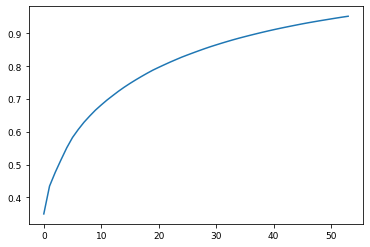

In [11]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
print(cumsum)

plt.plot(cumsum)

num_feats_pca = np.where(cumsum < 0.95)[0].shape[0]
print(num_feats_pca)

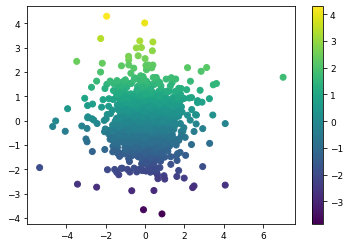

In [12]:
x, y = X_pca[:, 3], X_pca[:, 5]
plt.scatter(x, y, c=y)
plt.colorbar()

### Isomap

In [13]:
isomap_embedding = skl.manifold.Isomap(n_components=3, neighbors_algorithm='kd_tree', n_jobs=5)

X_isomap = isomap_embedding.fit_transform(X)

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


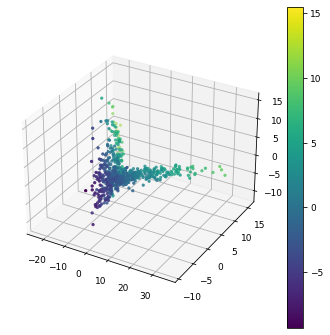

In [14]:
cm = 1/2.54
fig = plt.figure(figsize=(15*cm, 15*cm))
ax = fig.gca(projection='3d')
x, y, z = [X_isomap[:, i] for i in [0,1,2]]
s = ax.scatter3D(x, y, z, marker='.', c=y)
fig.colorbar(s)

### spectral embedding

In [15]:
spectral = skl.manifold.SpectralEmbedding(n_components=3, n_jobs=5) #n_neighbors=50

X_spectral = spectral.fit_transform(X)

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


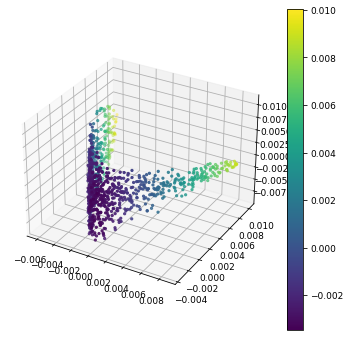

In [16]:
cm = 1/2.54
fig = plt.figure(figsize=(15*cm, 15*cm))
ax = fig.gca(projection='3d')
x, y, z = [X_spectral[:, i] for i in [0,1,2]]
s = ax.scatter3D(x, y, z, marker='.', c=y)
fig.colorbar(s)

**Isomap and Spectral embedding**
This is a continuous, single manifold. Data points for lower proximities are at the center of the manifold, and data points for higher proximities move away from the center in two directions. This suggests that 
1. data points with similar proximities are together, i.e. fmri responses capture information about proximity, 
2. since data points diverge into two directions, there may be *two varieties of explanations* for the same proximity value.

### mds: multidimensional scaling

In [17]:
mds_embedding = skl.manifold.MDS(n_components=3, n_jobs=5)

X_mds = mds_embedding.fit_transform(X)

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


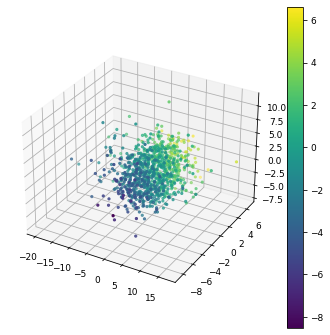

In [18]:
cm = 1/2.54
fig = plt.figure(figsize=(15*cm, 15*cm))
ax = fig.gca(projection='3d')
x, y, z = [X_mds[:, i] for i in [0,1,2]]
s = ax.scatter3D(x, y, z, marker='.', c=y)
fig.colorbar(s)

### tsne

In [19]:
tsne = skl.manifold.TSNE(n_components=3, 
                         learning_rate='auto', 
                         init='random', 
                         n_jobs=5)

In [20]:
X_tsne = tsne.fit_transform(X)

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


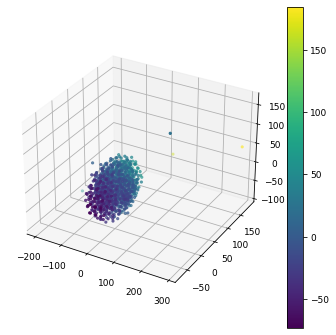

In [21]:
cm = 1/2.54
fig = plt.figure(figsize=(15*cm, 15*cm))
ax = fig.gca(projection='3d')
x, y, z = [X_tsne[:, i] for i in [0,1,2]]
s = ax.scatter3D(x, y, z, marker='.', c=y)
fig.colorbar(s)

**MDS and tSNE**
This single, blob-like manifold suggests that data points with similar proximities group together. 